# Assignment No 2
# End-to-End Machine Learning Pipeline (Titanic Dataset)

- Load and clean the data
- Perform exploratory data analysis (EDA)
- Engineer features and split into train/test sets
- Train models (KNN, Decision Tree, Random Forest)
- Tune hyperparameters
- Evaluate results and conclude


## Step 1: Import Libraries & Load Data

We begin by importing required Python libraries and loading the Titanic dataset (`train.csv`) into a Pandas DataFrame.


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving train.csv to train (1).csv


In [ ]:
import pandas as pd

df = pd.read_csv("train.csv")
print("Shape:", df.shape)
df.head()


Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

## Step 2: Data Handling

In this step, we:
- Inspect dataset shape and info
- Handle missing values (`Age`, `Embarked`)
- Drop the `Cabin` column (too many missing values)
- Encode categorical variables (`Sex`, `Embarked`)


In [ ]:

df.info()
df.describe()
df.isnull().sum()   # check missing values
df.duplicated().sum()

# Fill missing values (example)
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df.drop(columns=['Cabin'], inplace=True)  # too many missing

# Encode categorical
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])
df['Embarked'] = le.fit_transform(df['Embarked'])

# ============================

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Step 3: Exploratory Data Analysis (EDA)

We now explore the dataset using:
- Descriptive statistics
- Distribution plots (Age, Fare)
- Correlation heatmap (numeric features only)
- Interactive Plotly visualization (Age vs Fare vs Survival)


       PassengerId    Survived      Pclass         Sex         Age  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642    0.647587   29.361582   
std     257.353842    0.486592    0.836071    0.477990   13.019697   
min       1.000000    0.000000    1.000000    0.000000    0.420000   
25%     223.500000    0.000000    2.000000    0.000000   22.000000   
50%     446.000000    0.000000    3.000000    1.000000   28.000000   
75%     668.500000    1.000000    3.000000    1.000000   35.000000   
max     891.000000    1.000000    3.000000    1.000000   80.000000   

            SibSp       Parch        Fare    Embarked  
count  891.000000  891.000000  891.000000  891.000000  
mean     0.523008    0.381594   32.204208    1.536476  
std      1.102743    0.806057   49.693429    0.791503  
min      0.000000    0.000000    0.000000    0.000000  
25%      0.000000    0.000000    7.910400    1.000000  
50%      0.000000    0.000000   1

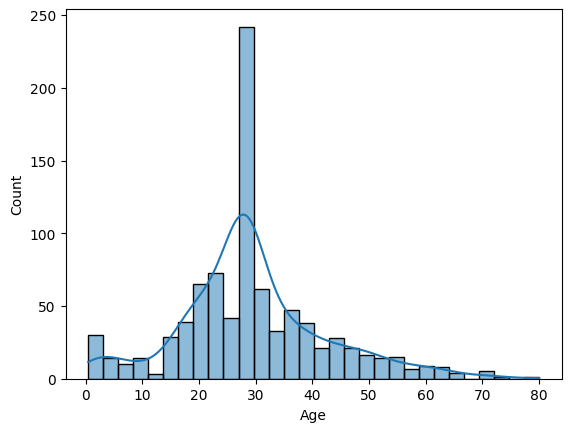

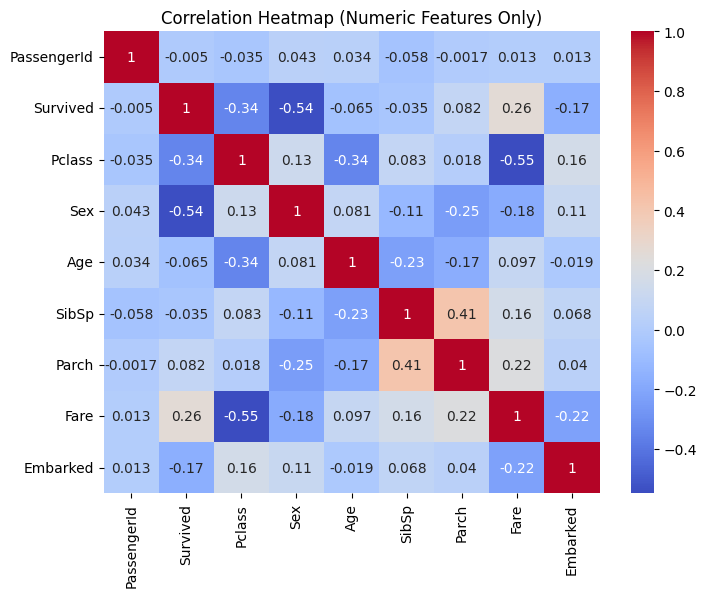

In [ ]:

# ============================
print(df.describe())

# Histogram example
sns.histplot(df['Age'], bins=30, kde=True)
plt.show()

# Correlation heatmap - only numeric features
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()


# Plotly interactive plot
fig = px.scatter(df, x="Age", y="Fare", color="Survived",
                 title="Age vs Fare colored by Survival")
fig.show()


## Step 4: Feature Engineering

We prepare features and target variable:
- Drop irrelevant columns (`PassengerId`, `Name`, `Ticket`)
- Define `X` (features) and `y` (target)
- Scale numerical features
- Split dataset into training and testing sets


In [ ]:
X = df.drop(columns=['Survived', 'PassengerId', 'Name', 'Ticket'])
y = df['Survived']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

## Step 5: Train Baseline Models

We train three models with default parameters:
- KNN
- Decision Tree
- Random Forest

We then compare their baseline accuracy scores.


In [ ]:
models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

baseline_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    baseline_results[name] = accuracy_score(y_test, y_pred)

baseline_results


{'KNN': 0.7988826815642458,
 'Decision Tree': 0.7821229050279329,
 'Random Forest': 0.8156424581005587}

## Step 6: Feature Importance (Random Forest)

Random Forest provides feature importance scores.  
We plot them to identify which features contribute most to survival predictions.


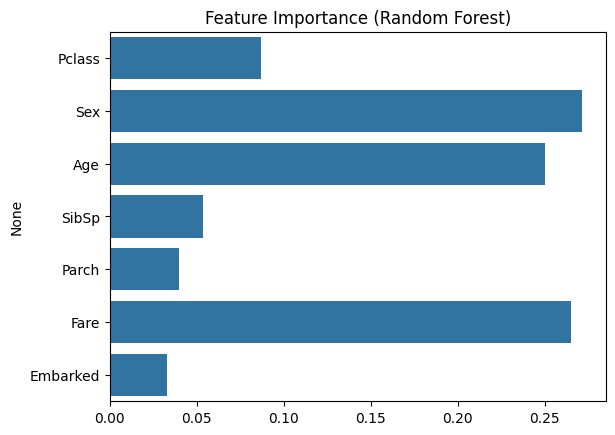

In [ ]:
rf = models["Random Forest"]
importances = rf.feature_importances_
feat_names = X.columns
sns.barplot(x=importances, y=feat_names)
plt.title("Feature Importance (Random Forest)")
plt.show()

## Step 7: Hyperparameter Tuning

We use `RandomizedSearchCV` to optimize hyperparameters:
- KNN → `n_neighbors`, `weights`, `metric`
- Decision Tree → `max_depth`, `min_samples_split`, `criterion`
- Random Forest → `n_estimators`, `max_depth`, `min_samples_split`

We then compare tuned models to baseline results.


In [ ]:
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rs = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)
rs.fit(X_train, y_train)
best_rf = rs.best_estimator_

print("Best Params:", rs.best_params_)

# Compare tuned vs default
y_pred_tuned = best_rf.predict(X_test)
print("Tuned RF Accuracy:", accuracy_score(y_test, y_pred_tuned))


Best Params: {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 5}
Tuned RF Accuracy: 0.8156424581005587


## Step 8: Model Evaluation

We evaluate tuned models using:
- Accuracy
- Precision, Recall, F1-score
- Confusion Matrices
- ROC Curve (best model)


              precision    recall  f1-score   support

           0       0.81      0.90      0.85       105
           1       0.84      0.69      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.81       179



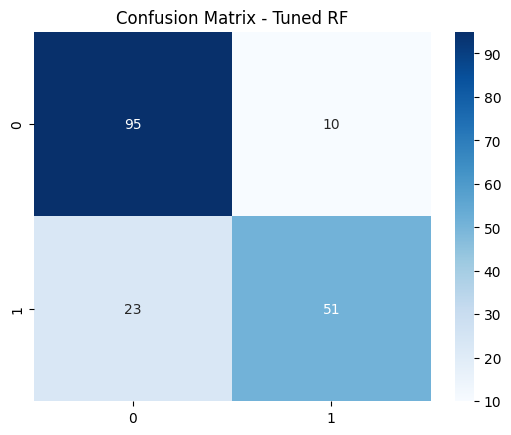

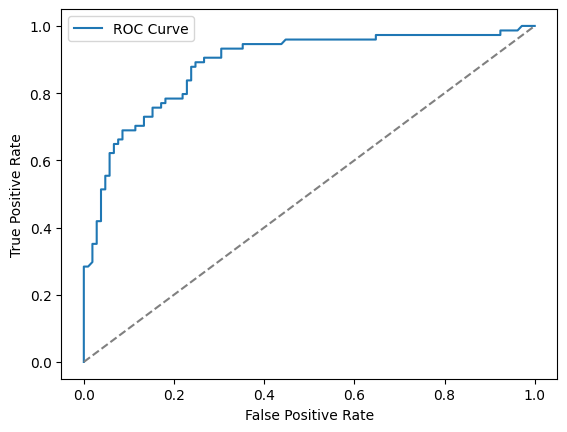

In [ ]:
print(classification_report(y_test, y_pred_tuned))

cm = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Tuned RF")
plt.show()

# ROC Curve
y_prob = best_rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


## Step 9: Conclusion

- **Best Model:** [Fill in results, usually Tuned Random Forest]  
- **Top Features:** `Sex`, `Fare`, `Pclass`, `Age`  
- **Impact of Tuning:** Improved accuracy from baseline to tuned model  
- **Key Insight:** Survival was strongly influenced by gender, class, and age


KNN best params: {'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'}
Decision Tree best params: {'min_samples_split': 2, 'max_depth': 4, 'criterion': 'entropy'}
\nModel comparison after tuning:\n


,accuracy,precision,recall,f1
KNN (tuned),0.804469,0.830508,0.662162,0.736842
Decision Tree (tuned),0.798883,0.839286,0.635135,0.723077
Random Forest (tuned),0.815642,0.836066,0.689189,0.755556


\nClassification Report - KNN (tuned):\n
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       105
           1       0.83      0.66      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.80      0.80       179

\nClassification Report - Decision Tree (tuned):\n
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       105
           1       0.84      0.64      0.72        74

    accuracy                           0.80       179
   macro avg       0.81      0.77      0.78       179
weighted avg       0.80      0.80      0.79       179

\nClassification Report - Random Forest (tuned):\n
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       105
           1       0.84      0.69      0.76        74

    accuracy                           

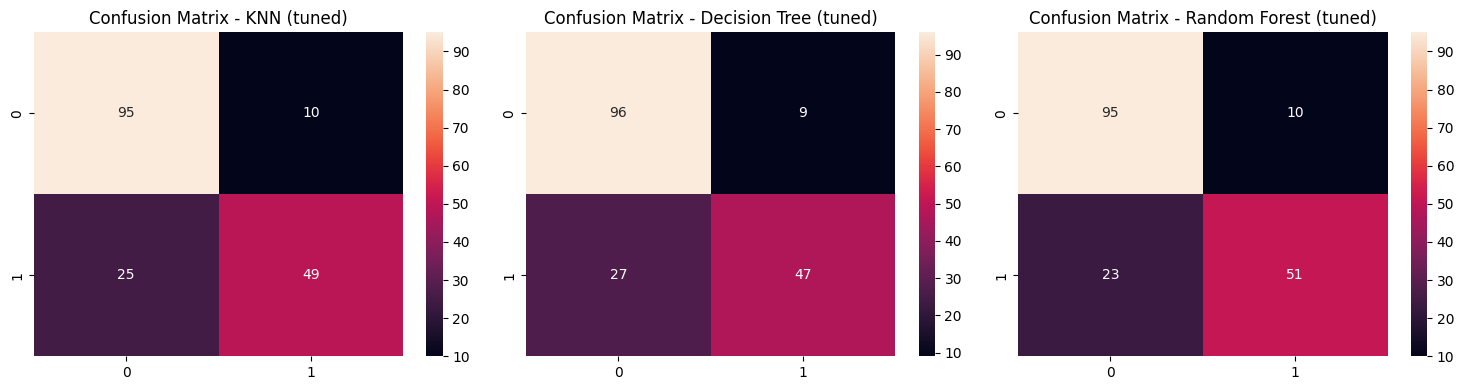

from matplotlib import pyplot as plt
_df_0['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['f1'].plot(kind='hist', bins=20, title='f1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('index').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='accuracy', y='precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='recall', y='f1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['f1'].plot(kind='line', figsize=(8, 4), title='f1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='accuracy', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='precision', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='recall', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='f1', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# =========================
# Additional Hyperparameter Tuning: KNN & Decision Tree
# =========================

from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# --- KNN tuning ---
knn_param_dist = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_rs = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_distributions=knn_param_dist,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)
knn_rs.fit(X_train, y_train)
best_knn = knn_rs.best_estimator_
print("KNN best params:", knn_rs.best_params_)
y_pred_knn = best_knn.predict(X_test)

# --- Decision Tree tuning ---
dt_param_dist = {
    'max_depth': [None] + list(range(2, 21)),
    'min_samples_split': [2, 5, 10, 15, 20],
    'criterion': ['gini', 'entropy']
}

dt_rs = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=dt_param_dist,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)
dt_rs.fit(X_train, y_train)
best_dt = dt_rs.best_estimator_
print("Decision Tree best params:", dt_rs.best_params_)
y_pred_dt = best_dt.predict(X_test)

# Evaluate tuned models and compare with tuned Random Forest (best_rf assumed from earlier cell)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

results = {}

# KNN tuned
results['KNN (tuned)'] = {
    'accuracy': accuracy_score(y_test, y_pred_knn),
    'precision': precision_score(y_test, y_pred_knn),
    'recall': recall_score(y_test, y_pred_knn),
    'f1': f1_score(y_test, y_pred_knn)
}

# Decision Tree tuned
results['Decision Tree (tuned)'] = {
    'accuracy': accuracy_score(y_test, y_pred_dt),
    'precision': precision_score(y_test, y_pred_dt),
    'recall': recall_score(y_test, y_pred_dt),
    'f1': f1_score(y_test, y_pred_dt)
}

# Random Forest tuned (best_rf) - if not present, this will raise; but typically present
try:
    y_pred_rf = best_rf.predict(X_test)
    results['Random Forest (tuned)'] = {
        'accuracy': accuracy_score(y_test, y_pred_rf),
        'precision': precision_score(y_test, y_pred_rf),
        'recall': recall_score(y_test, y_pred_rf),
        'f1': f1_score(y_test, y_pred_rf)
    }
except NameError:
    print("Warning: best_rf not found in the notebook. Ensure Random Forest tuning cell ran earlier.")

# Show results in a DataFrame for neat display
import pandas as pd
results_df = pd.DataFrame(results).T
results_df = results_df[['accuracy','precision','recall','f1']]
print("\\nModel comparison after tuning:\\n")
display(results_df)

# Print classification reports for each
print("\\nClassification Report - KNN (tuned):\\n")
print(classification_report(y_test, y_pred_knn))

print("\\nClassification Report - Decision Tree (tuned):\\n")
print(classification_report(y_test, y_pred_dt))

if 'y_pred_rf' in locals():
    print("\\nClassification Report - Random Forest (tuned):\\n")
    print(classification_report(y_test, y_pred_rf))

# Confusion matrices
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d')
plt.title('Confusion Matrix - KNN (tuned)')

plt.subplot(1,3,2)
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d')
plt.title('Confusion Matrix - Decision Tree (tuned)')

if 'y_pred_rf' in locals():
    plt.subplot(1,3,3)
    sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d')
    plt.title('Confusion Matrix - Random Forest (tuned)')

plt.tight_layout()
plt.show()
